In [1]:
import scipy
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

import utils.utils as utils
import utils.utils_features as utils_features
import utils.utils_preprocessing as utils_preprocessing
import utils.utils_plots as utils_plots
from utils.utils_models import LightGBMForecastingModel, NaiveForecastingModel
from sklearn.model_selection import TimeSeriesSplit

sns.set_theme(style="darkgrid")

In [2]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

In [3]:
df_kaggle = utils_preprocessing.preprocess_columns(df_kaggle)

In [4]:
# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
df_kaggle = utils_preprocessing.fill_in_missing_dates(df_kaggle)

# Interpolation and fill-in function
def interpolate_sku(group):
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)

/Users/matteogiaretti/Python/hp_use_case/utils/utils_preprocessing.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(["min", "max"]).reset_index()
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_83917/3060182721.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False, observed=False).apply(interpolate_sku)


In [5]:
# Generate features
df_kaggle = utils_features.features_time_related(df_kaggle)
df_kaggle = utils_features.features_lag(df=df_kaggle, col='inventory_units', lags=[13])
df_kaggle = utils_features.features_lag(df=df_kaggle, col='sales_units', lags=[13, 14, 15])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='inventory_units', window_sizes=[4, 8])
df_kaggle = utils_features.features_rolling(df=df_kaggle, col='sales_units', window_sizes=[4, 8])

In [6]:
df_kaggle = df_kaggle.rename(columns={'inventory_units': 'y'}).set_index('date').sort_index()

# Validation

In [7]:
X_train, X_test, y_train, y_test = utils.train_test_split(df_kaggle, forecasting_horizon=13*2, target_col="y")

In [8]:
cv_split = TimeSeriesSplit(n_splits=10, test_size=13)

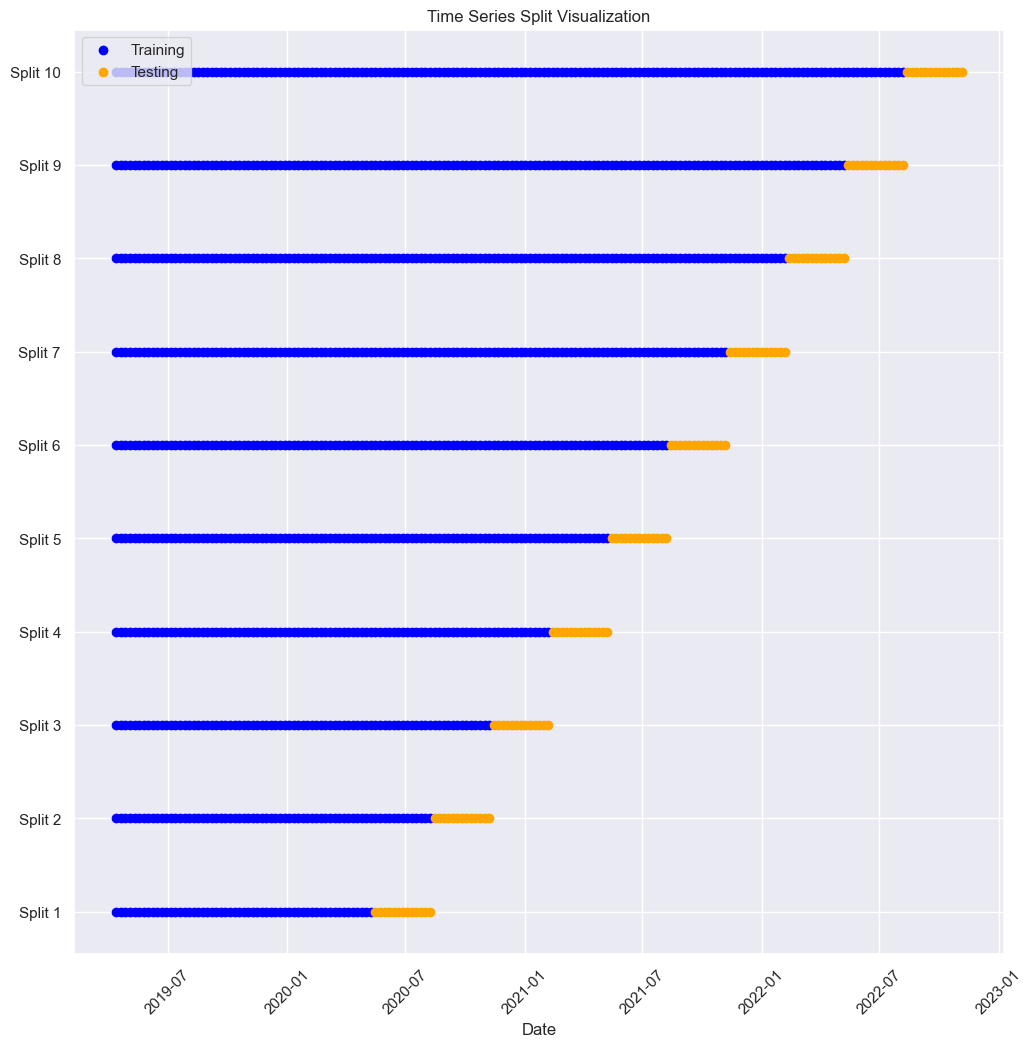

<Figure size 1400x200 with 0 Axes>

In [35]:
utils_plots.plot_time_series_split_with_dates(
    ts_splitter=cv_split, 
    df=X_train)

In [10]:
parameters = {
    'objective': ['regression'],
    "boosting_type": ["gbdt"],
    'metric': ['rmse'],
    'importance_type': ['split'],
    "max_depth": [-1, 1, 3, 4, 5, 6, 10],
    "num_leaves": [10, 20, 30, 40, 100, 120, 150, 200, 250],
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    "n_estimators": [50, 100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7, 1, 1.2, 1.5],
    "reg_alpha": [0, 0.01, 1, 2, 5, 7, 10, 50, 100],
    "reg_lambda": [0, 0.01, 1, 5, 10, 20, 50, 100]
}


random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    cv=cv_split, 
    param_distributions=parameters,
    verbose=1
    )
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6310
[LightGBM] [Info] Number of data points in the train set: 15403, number of used features: 36
[LightGBM] [Info] Start training from score 69.730313
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_col_wise=

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6310
[LightGBM] [Info] Number of data points in the train set: 15403, number of used features: 36
[LightGBM] [Info] Start training from score 69.730313
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work/LightGBM/LightGBM/lightgbm-python/src/io/config_auto.cpp, line 382 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /Users/runner/work

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6314
[LightGBM] [Info] Number of data points in the train set: 15416, number of used features: 36
[LightGBM] [Info] Start training from score 69.731696
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6315

/Users/matteogiaretti/Python/hp_use_case/.venv2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/matteogiaretti/Python/hp_use_case/.venv2/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/matteogiaretti/Python/hp_use_case/.venv2/lib/python3.13/site-packages/lightgbm/sklearn.py", line 1189, in fit
    super().fit(
    ~~~~~~~~~~~^
        X,
        ^^
    ...<11

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6337
[LightGBM] [Info] Number of data points in the train set: 15533, number of used features: 36
[LightGBM] [Info] Start training from score 69.755636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=13),
                   estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.5, 0.7, 1,
                                                             1.2, 1.5],
                                        'importance_type': ['split'],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'max_depth': [-1, 1, 3, 4, 5, 6, 10],
                                        'metric': ['rmse'],
                                        'n_estimators': [50, 100, 300, 500, 700,
                                                         900, 1000],
                                        'num_leaves': [10, 20, 30, 40, 100, 120,
                                                       150, 200, 250],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.01, 1, 2, 5, 7, 10,
                                                      50, 100],
                                        'reg_lambda': [0, 0.01, 1, 5, 10, 20,
                                                       50, 100]},
                   verbose=1)

In [11]:
best_model = random_search.best_estimator_
optimal_params = best_model.get_params()

In [12]:
optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5,
 'importance_type': 'split',
 'learning_rate': 0.5,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'num_leaves': 20,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

In [8]:
optimal_params = {
    'boosting_type': 'gbdt',
    'class`_weight': None,
    'colsample_bytree': 1,
    'importance_type': 'split',
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 700,
    'n_jobs': None,
    'num_leaves': 120,
    'objective': None,
    'random_state': None,
    'reg_alpha': 2,
    'reg_lambda': 5,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'metric': 'rmse'
}

optimal_params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': np.float64(0.9914924607394691),
    'importance_type': 'split',
    'learning_rate': np.float64(0.027590738215604697),
    'max_depth': np.int64(10),
    'min_child_samples': 25,
    'min_child_weight': 0.034,
    'min_split_gain': 0.0,
    'n_estimators': 50,
    'n_jobs': None,
    'num_leaves': 157,
    'objective': 'regression',
    'random_state': 222,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'subsample': np.float64(0.6006545748134953),
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'bagging_fraction': 0.418,
    'bagging_seed': 11,
    'feature_fraction': 0.379,
    'metric': 'rmse',
    'min_data_in_leaf': 106,
    'verbosity': -1,
    }

## Evaluation

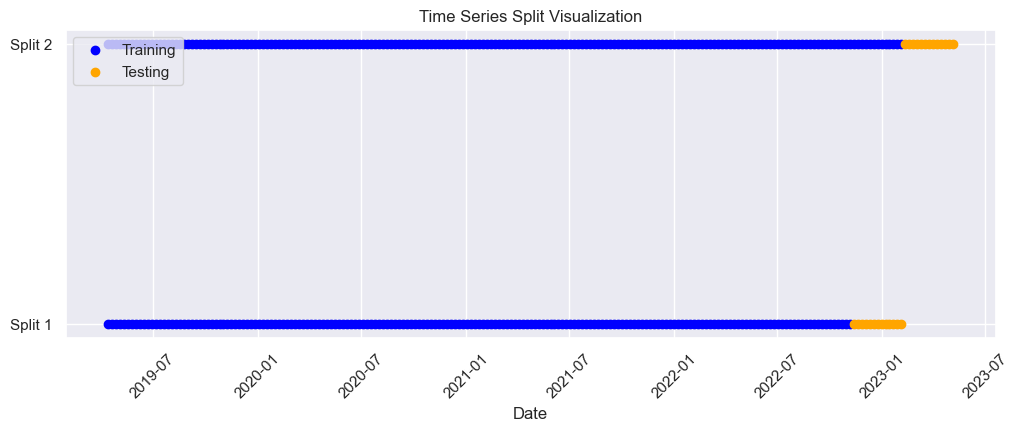

<Figure size 1400x200 with 0 Axes>

In [9]:
tss = TimeSeriesSplit(2, test_size=13)
utils_plots.plot_time_series_split_with_dates(
    ts_splitter=tss, 
    df=df_kaggle)

In [10]:
fc_model = LightGBMForecastingModel(
    hyperparameters=optimal_params
    )
results_cv = fc_model.cross_validate(df_kaggle, n_splits=2)

Model evaluation completed. RMSE: 54.116
Model evaluation completed. RMSE: 52.138
Average RMSE from cross-validation: 53.1270


In [12]:
fc_model = LightGBMForecastingModel(
    hyperparameters=optimal_params
    )
fc_model.train(X_train, y_train)
fc_model.save_model("./models/lightgbm.pk")

## Visualisation

In [12]:
df_preds = utils.predict_last_13_weeks(df_kaggle, fc_model)
df_final = df_kaggle.merge(df_preds.reset_index(), on=['date', 'sku'], how='left')

/Users/matteogiaretti/Python/hp_use_case/utils/utils_models.py:104: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return X["sku"].map(self.last_values).fillna(method="ffill").values


In [13]:
num_select = 4
#list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
list_skus = df_preds["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
#list_skus = df_preds["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

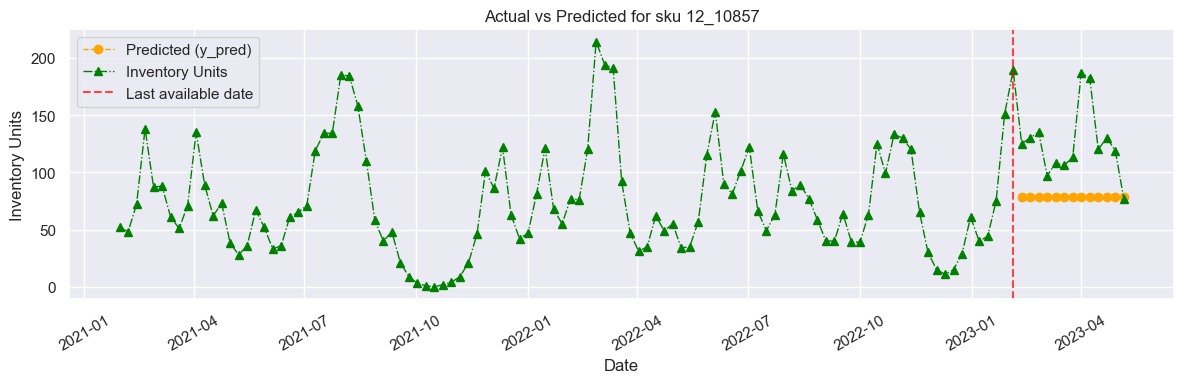

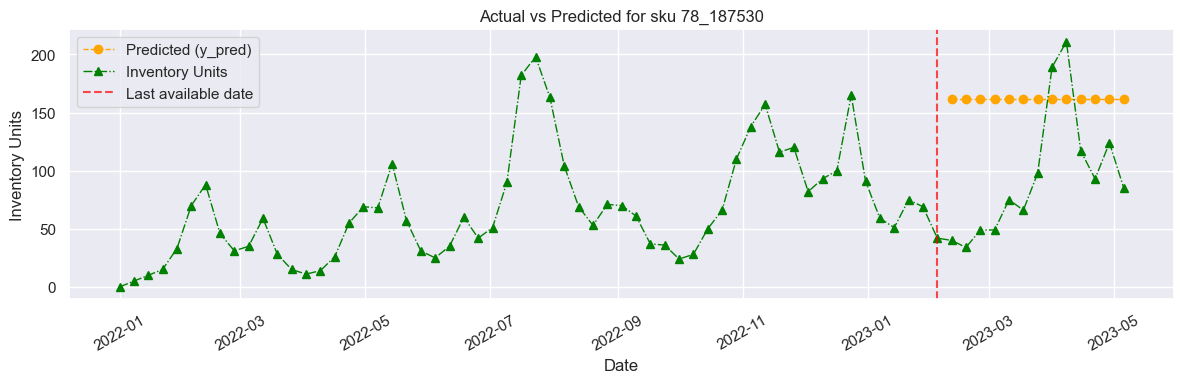

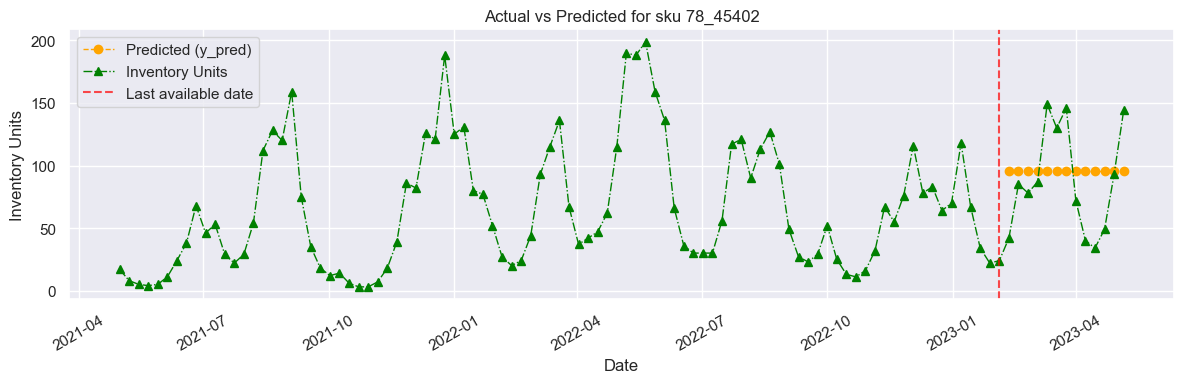

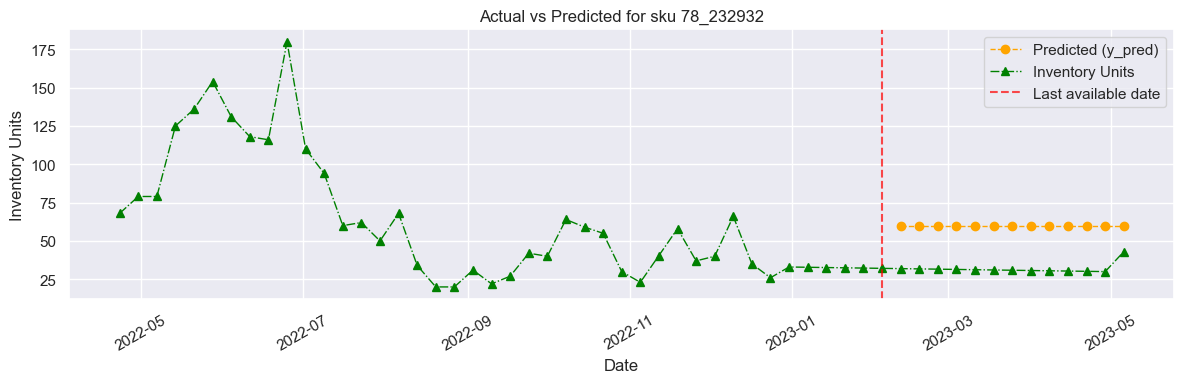

In [14]:
date_present = df_final['date'].max() - pd.DateOffset(weeks=13)
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_final, sku, vline_dates=[date_present])

In [40]:
df_kaggle[df_kaggle['sku'] == '78_45402'][['sku', 'y', 'inventory_units_lag_13', 'inventory_units_rolling_mean_4w']].tail(25)

,sku,y,inventory_units_lag_13,inventory_units_rolling_mean_4w
date,,,,
2022-11-19,78_45402,55.0,127.0,112.75
2022-11-26,78_45402,76.0,101.0,107.75
2022-12-03,78_45402,116.0,49.0,97.50
2022-12-10,78_45402,78.0,27.0,76.00
2022-12-17,78_45402,83.0,23.0,50.00
2022-12-24,78_45402,64.0,29.0,32.00
2022-12-31,78_45402,70.0,52.0,32.75
2023-01-07,78_45402,118.0,25.0,32.25
2023-01-14,78_45402,67.0,13.0,29.75


In [47]:
df_kaggle[df_kaggle['sku'] == '78_45402'][['sku', 'y']].iloc[-17:-13]

,sku,y
date,,
2023-01-14,78_45402,67.0
2023-01-21,78_45402,34.0
2023-01-28,78_45402,22.0
2023-02-04,78_45402,24.0


In [48]:
df_kaggle[df_kaggle['sku'] == '78_45402'][['sku', 'y']].iloc[-17:-13]['y'].sum()/4

np.float64(36.75)

In [24]:
X_test.index.max()

Timestamp('2023-05-06 00:00:00')

In [21]:
df_kaggle.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units', 'y',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'sin_day_of_month', 'cos_day_of_month', 'sin_week_of_year',
       'cos_week_of_year', 'sin_month_of_year', 'cos_month_of_year',
       'inventory_units_lag_13', 'sales_units_lag_13', 'sales_units_lag_14',
       'sales_units_lag_15', 'inventory_units_rolling_mean_4w',
       'inventory_units_rolling_std_4w', 'inventory_units_rolling_sum_4w',
       'inventory_units_rolling_mean_8w', 'inventory_units_rolling_std_8w',
       'inventory_units_rolling_sum_8w', 'sales_units_rolling_mean_4w',
       'sales_units_rolling_std_4w', 'sales_units_rolling_sum_4w',
       'sales_units_rolling_mean_8w', 'sales_units_rolling_std_8w',
       'sales_units_rolling_sum_8w'],
      dtype='object')